In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [3]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df_base = df[base]
df_base

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

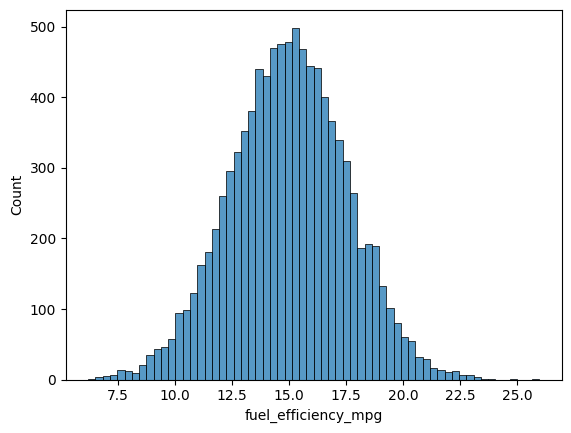

In [4]:
sns.histplot(df_base.fuel_efficiency_mpg)

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

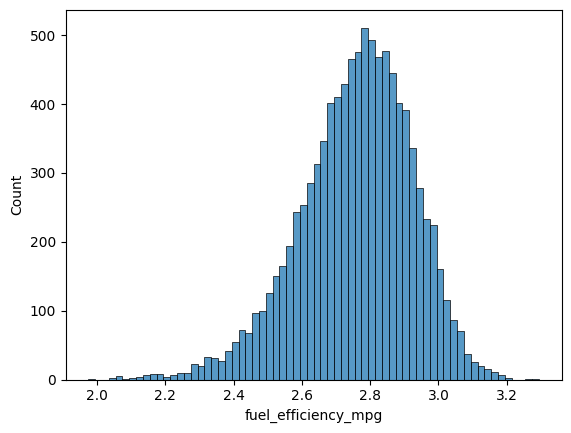

In [5]:
fuel_logs = np.log1p(df_base.fuel_efficiency_mpg)
sns.histplot(fuel_logs)

In [6]:
#Q1

df_base.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [7]:
#Q2 

df_base.horsepower.median()

np.float64(149.0)

In [8]:
n = len(df)

n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - (n_test + n_val)

n_train, n_val, n_test

(5824, 1940, 1940)

In [9]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [10]:
df_base.iloc[idx[:10]]

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209
4562,180,120.0,3551.398040,2013,12.145734
5885,210,118.0,3620.351977,2018,11.378399
3746,150,152.0,2524.407794,2012,16.667294
7109,160,151.0,2752.964230,2009,15.819367
2698,250,147.0,3202.856567,2020,14.100998


In [11]:
df_base_train = df_base.iloc[idx[:n_train]]
df_base_test = df_base.iloc[idx[n_train:n_train+n_test]] 
df_base_val = df_base.iloc[idx[n_train+n_test:]]

In [12]:
df_base_train = df_base_train.reset_index(drop=True)
df_base_test = df_base_test.reset_index(drop=True)
df_base_val = df_base_val.reset_index(drop=True)

In [13]:
# No need to take the logarithm since we have a normal distribution and not a long tail distribution

y_train = np.log1p(df_base_train.fuel_efficiency_mpg.values)
y_test = np.log1p(df_base_test.fuel_efficiency_mpg.values)
y_val = np.log1p(df_base_val.fuel_efficiency_mpg.values)


In [14]:
del df_base_train['fuel_efficiency_mpg']
del df_base_test['fuel_efficiency_mpg']
del df_base_val['fuel_efficiency_mpg']

In [15]:
def prepare_X(df, empty_val_replacement=0):
    df = df.copy()
    df.horsepower = df.horsepower.fillna(empty_val_replacement)
    X = df.values
    return X

In [16]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]
    pass

In [17]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [18]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]
    pass

In [19]:
# Option 1 (replace the empty value with 0)

X_train = prepare_X(df_base_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_base_val)
y_pred = w0 + X_val.dot(w)


score = rmse(y_val, y_pred)
score = round(score, 2)
score

np.float64(0.04)

In [20]:
car = df_base_test.iloc[60].to_dict()
car

df_small = pd.DataFrame([car])

X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)

y_pred = y_pred[0]

np.expm1(y_pred)

np.float64(14.72072572392224)

In [21]:
np.expm1(y_test[60])

np.float64(15.279495092594727)

In [22]:
# Option 2 (replace the empty value with mean)

mean_hp = df_base_train.horsepower.mean()

X_train = prepare_X(df_base_train, mean_hp)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_base_val)
y_pred = w0 + X_val.dot(w)

score = rmse(y_val, y_pred)
score = round(score, 2)
score

np.float64(0.04)

In [23]:
# Q4
# Tuning the model

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    
    X_train = prepare_X(df_base_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_base_val)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)

    print(r, w0, score)

0 3.6646662472218297 0.037851962767782146
0.01 3.1688134470074534 0.03788071228961772
0.1 1.4288369989383432 0.03852964389623198
1 0.22012861946726972 0.039463991684721686
5 0.04624885656570121 0.03962930595279233
10 0.023271722731248758 0.039651714533160236
100 0.0023413689852701753 0.03967223909895921


In [24]:
def perform_regression_with_different_seed(df, seed_list):
    df = df.copy()
    
    n = len(df)
    n_test = int(n * 0.2)
    n_val = int(n * 0.2)
    n_train = n - (n_test + n_val)

    score_list = []
    
    for seed in seed_list:
        idx = np.arange(n)
        np.random.seed(seed)
        np.random.shuffle(idx)

        df_train = df.iloc[idx[:n_train]]
        df_test = df.iloc[idx[n_train:n_train+n_test]] 
        df_val = df.iloc[idx[n_train+n_test:]]
        
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)
    
        y_train = df_train.fuel_efficiency_mpg.values
        y_test = df_test.fuel_efficiency_mpg.values
        y_val = df_val.fuel_efficiency_mpg.values
    
        del df_train['fuel_efficiency_mpg']
        del df_test['fuel_efficiency_mpg']
        del df_val['fuel_efficiency_mpg']
    
        X_train = prepare_X(df_train)
        w0, w = train_linear_regression(X_train, y_train)
    
        X_val = prepare_X(df_val)
        y_pred = w0 + X_val.dot(w)
    
        score = rmse(y_val, y_pred)
        score = round(score, 2)
        score_list.append(score.item())

    return score_list
    

In [25]:
score_list = perform_regression_with_different_seed(df_base, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
std_score_list = np.std(score_list)
round(std_score_list, 3)

np.float64(0.008)

In [27]:
def perform_regression_with_reg_with_different_seed(df, seed_list, reg=0.01):
    df = df.copy()
    
    n = len(df)
    n_test = int(n * 0.2)
    n_val = int(n * 0.2)
    n_train = n - (n_test + n_val)

    score_list = []
    
    for seed in seed_list:
        idx = np.arange(n)
        np.random.seed(seed)
        np.random.shuffle(idx)

        df_train = df.iloc[idx[:n_train]]
        df_test = df.iloc[idx[n_train:n_train+n_test]] 
        df_val = df.iloc[idx[n_train+n_test:]]
        
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)
    
        y_train = df_train.fuel_efficiency_mpg.values
        y_test = df_test.fuel_efficiency_mpg.values
        y_val = df_val.fuel_efficiency_mpg.values
    
        del df_train['fuel_efficiency_mpg']
        del df_test['fuel_efficiency_mpg']
        del df_val['fuel_efficiency_mpg']
    
        X_train = prepare_X(df_train)
        w0, w = train_linear_regression_reg(X_train, y_train, reg)
    
        X_val = prepare_X(df_val)
        y_pred = w0 + X_val.dot(w)
    
        score = rmse(y_val, y_pred)
        score = round(score, 2)
        score_list.append(score.item())

    return score_list
    

In [28]:
score_list = perform_regression_with_reg_with_different_seed(df_base, [9], 0.001)
score_list

[0.52]

In [29]:
score_list = perform_regression_with_reg_with_different_seed(df_base, [9])
score_list

[0.52]